In [2]:
# Import dati dalla prof
from scipy.io import loadmat
import numpy as np
import scipy.linalg as spl
import RisolviSis as RS
import matplotlib.pyplot as plt
import math
dati = loadmat('testF.mat')
A1 = dati["A"]
b1 = dati["b"]


### Equazioni Normali

In [4]:
# La risoluzione di un sistema sovradeterminato risulta essere un problema mal posto
# in quanto potrebbe accadere che la soluzione non esista o non sia unica. Per
# renderlo ben posto lo si riformula come "risoluzione nel senso dei minimi quadrati"
# Definito un vettore residuo r(x) = Ax - b, cerchiamo una x* che rende minima
# la norma 2 al quadrato del residuo.
def eqnorm(A, b):

    # Se la matrice A ha rango massimo ed è ben condizionata (condizione necessaria)
    # possiamo procedere con il metodo delle equazioni normali: poniamo G = A.T @ A,
    # matrice simmetrica che viene associata alla x che si vuole cercare andando
    # a definire una funzione F(x) per la quale il gradiente si annulli.
    # Questa nuova matrice sarà quadrata n x n con determinante diverso da 0.
    G = A.T @ A

    print("Indice di condizionamento di G ", np.linalg.cond(G))

    # Il problema descritto precedentemente si può risolvere facilmente grazie alla
    # risoluzione del seguente sistema lineare: G x = A.T b. Siccome G è simmetrica
    # e definita positiva, il sistema può essere risolto utilizzando il metodo
    # di Cholesky. In questo modo sono anche sicuro che il risultato ottenuto sia
    # un minimo della funzione F(x).
    f = A.T @ b
    L = spl.cholesky(G, lower=True)

    y, flag = RS.Lsolve(L, f)

    if (flag == 0):
        x, flag = RS.Usolve(L.T, y)

    return x


In [11]:
# La soluzione del problema dei minimi quadrati mediante equazioni normali richiede
# solo che la matrice A del sistema sovradeterminato A x = b abbia rango massimo.
# L’idea è di individuare una trasformazione ortogonale che, applicata al residuo
# r = Ax-b, lo trasformi in modo tale da rendere più facile la soluzione del problema
# di minimizzarne la norma: le trasformazioni ortogonali lasciano inalterata la
# norma 2 di un vettore.

""" sol = eqnorm(A1, b1)
print("Soluzione nel senso dei minimi quadrati:\n  ", sol)
print("Norma soluzione: ", np.linalg.norm(sol))

# Di quanto ci discostiamo dalla soluzione esatta?
x_esatta = np.ones_like(sol)
err = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)
print("Errore soluzione Eqnorm: ", err * 100) """


' sol = eqnorm(A1, b1)\nprint("Soluzione nel senso dei minimi quadrati:\n  ", sol)\nprint("Norma soluzione: ", np.linalg.norm(sol))\n\n# Di quanto ci discostiamo dalla soluzione esatta?\nx_esatta = np.ones_like(sol)\nerr = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)\nprint("Errore soluzione Eqnorm: ", err * 100) '

### QRLS

In [5]:
# La risoluzione di un sistema sovradeterminato risulta essere un problema mal posto
# in quanto potrebbe accadere che la soluzione non esista o non sia unica. Per
# renderlo ben posto lo si riformula come "risoluzione nel senso dei minimi quadrati"
# Definito un vettore residuo r(x) = Ax - b, cerchiamo una x* che rende minima
# la norma 2 al quadrato del residuo.
# Se A ha rango massimo ed è mediamente mal condizionata si può usare il metodo QR
# per la soluzione del problema dei minimi quadrati, calcolando i due fattori Q
# ed R di A, lavorando sempre solo sulla matrice A, senza dover passare alla matrice
# A.T @ A che è molto più mal condizionata e sfruttando una fattorizzazione abbastanza
# stabile. Sotto queste condizioni il risultato sarà molto più preciso di altri metodi.
def QRLS(A, b):
    n = A.shape[1]
    Q, R = spl.qr(A)

    # Risolvo il sistema triangolare superiore: prime n righe e tutte le colonne
    # per avere una matrice quadrata
    h = Q.T @ b
    x, flag = RS.Usolve(R[0:n, :], h[0:n])
    residuo = np.linalg.norm(h[n:])**2

    return x, residuo


In [ ]:
sol, residuo = QRLS(A1, b1)
print("Soluzione nel senso dei minimi quadrati:\n  ", sol)
print("Residuo: ", residuo)
print("Norma soluzione: ", np.linalg.norm(sol))

# Di quanto ci discostiamo dalla soluzione esatta?
x_esatta = np.ones_like(sol)
err = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)
print("Errore soluzione QRLS: ", err * 100)


### SVDLS

In [6]:
# La risoluzione di un sistema sovradeterminato risulta essere un problema mal posto
# in quanto potrebbe accadere che la soluzione non esista o non sia unica. Per
# renderlo ben posto lo si riformula come "risoluzione nel senso dei minimi quadrati"
# Definito un vettore residuo r(x) = Ax - b, cerchiamo una x* che rende minima
# la norma 2 al quadrato del residuo.
# Se A non ha rango massimo si sfrutta il metodo di decomposizione ai valori singolari,
# secondo il quale la matrice A viene decomposto in due vettori U e V.T detti rispettivamente
# vettori singolari sinistri e destri per cui valgono le seguenti proprietà:
# - tutti i valori singolari sono reali >= 0
# - il rapporto tra il massimo e il minimo dei singolari ci dà l'indice di condizionamento
#   di A
# - i valori singolari non nulli ci dicono quale é il rango di A.
# - il primo dei valori singolari é sempre il massimo.
def SVDLS(A, b):
    n = A.shape[1]  # numero di colonne di A
    m = A.shape[0]  # numero di righe

    # La decomposizione di A
    U, s, V_T = spl.svd(A)
    V = V_T.T

    # Calcolo del rango della matrice, numero dei valori singolari maggiori di una soglia
    thresh = np.spacing(1) * m * s[0]
    k = np.count_nonzero(s > thresh)

    # Controllo sul rango
    print("Rango: ", k)
    if (k < n):
        print("La matrice non è a rango massimo")
    else:
        print("La matrice è a rango massimo")

    # La condizione aggiuntiva che inseriamo per risolvere il problema dei minimi
    # quadrati: minimizzo il residuo cercando una soluzione fra le infinite di
    # norma minima.
    d = U.T @ b
    d1 = d[:k].reshape(k, 1)
    s1 = s[:k].reshape(k, 1)
    # Risolve il sistema diagonale di dimensione kxk avene come matrice dei
    # coefficienti la matrice Sigma.
    c = d1 / s1
    x = V[:, :k] @ c
    residuo = np.linalg.norm(d[k:])**2
    return x, residuo


In [ ]:
sol, residuo = SVDLS(A1, b1)
print("Soluzione nel senso dei minimi quadrati:\n  ", sol)
print("Residuo: ", residuo)
print("Norma soluzione: ", np.linalg.norm(sol))

# Di quanto ci discostiamo dalla soluzione esatta?
x_esatta = np.ones_like(sol)
err = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)
print("Errore soluzione SVDLS: ", err * 100)


### Confronti

Condizionamento di A:  356547012997.1385
Indice di condizionamento di G  1.7553532258796628e+20
Errore eqn 0.0015167608393093837 %
Errore qr 0.0001793601604944298 %
Rango:  5
La matrice è a rango massimo
Errore svd 0.00017936005855011229 %


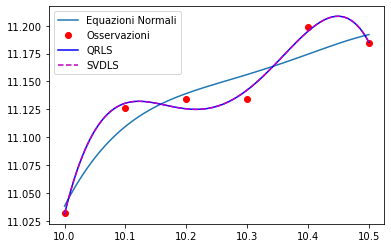

In [7]:
# Vediamo quanto è precisa l'approssimazione con ogni algoritmo.
x = np.arange(10, 10.6, 0.5 / 5)
y = np.array([11.0320, 11.1263, 11.1339, 11.1339, 11.1993, 11.1844])

# Grado del polinomio e gradi di libertà.
n = 4
n1 = n + 1
A = np.vander(x, increasing=True)[:, :n1]

# Indice di condizionamento della matrice.
condA = np.linalg.cond(A)
print("Condizionamento di A: ", condA)
xv = np.linspace(np.min(x), np.max(x), 100)

# Con il metodo delle equazioni normali.
alpha_eqn = eqnorm(A, y)
pol_eqn = np.polyval(np.flip(alpha_eqn), xv)
errore_eqn = np.linalg.norm(y - np.polyval(np.flip(alpha_eqn), x))**2
plt.plot(xv, pol_eqn, x, y, 'ro')
print("Errore eqn", errore_eqn, "%")

# Con il metodo QRLS.
alpha_qr, residuo_qr = QRLS(A, y)
pol_qr = np.polyval(np.flip(alpha_qr), xv)
plt.plot(xv, pol_qr, 'b')
print("Errore qr", residuo_qr, "%")

# Con il metodo SVDLS.
alpha_svd, residuo_svd = SVDLS(A, y)
pol_svd = np.polyval(np.flip(alpha_svd), xv)
plt.plot(xv, pol_svd, 'm--')
print("Errore svd", residuo_svd, "%")

# A causa dell'elevato mal condizionamento di G il metodo delle
# equazioni normali non approssima i dati in maniera accurata. Gli
# altri due metodi sono invece più precisi.
plt.legend(['Equazioni Normali', 'Osservazioni', 'QRLS', 'SVDLS'])
plt.show()


### Approssimazioni di dati sperimentali: cerchio

Rango:  3
La matrice è a rango massimo
Norma 2 al quadrato dell'errore  36.698412698412625


(-1.0609720865369214, 6.681792039720544, -0.994885297355498, 6.748853551323755)

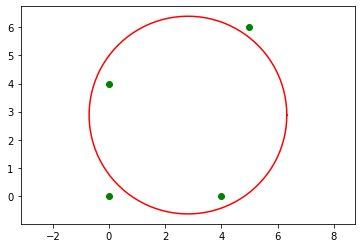

In [12]:
# Dati un insieme di punti
px = np.array([0, 4, 0, 5])
py = np.array([0, 0, 4, 6])

# Costruisco il sistema lineare sovradeterminato come richiesto:
# A matrice dei coefficienti e b dato dai termini noti.
A = np.array([[0, 0, 1], [4, 0, 1], [0, 4, 1], [5, 6, 1]])
b = np.array([[0], [-16], [-16], [-61]])

# Applico l'algoritmo.
a, err = SVDLS(A, b)
print("Norma 2 al quadrato dell'errore ", err)

# Calcolo il centro
cx = -a[0]/2
cy = -a[1]/2

# Calcolo il raggio con la formula data
r = math.sqrt((a[0]**2) / 4 + (a[1]**2) / 4 - a[2])
t = np.linspace(0, 2 * math.pi, 100)

# Costruisco le due componenti parametriche della circonferemza
x = cx + r * np.cos(t)
y = cy + r * np.sin(t)
plt.plot(x, y, 'r-')
plt.plot(px, py, 'go')
plt.axis('equal')


### Approssimazioni di dati sperimentali: miglior approssimazione

[[1.00000000e+00 9.99600080e-01 9.99200320e-01 9.98800720e-01]
 [1.00000000e+00 7.78255813e-01 6.05682111e-01 4.71375624e-01]
 [1.00000000e+00 6.06045629e-01 3.67291305e-01 2.22595290e-01]
 [1.00000000e+00 1.35240582e-01 1.82900149e-02 2.47355226e-03]
 [1.00000000e+00 3.35026810e-04 1.12242963e-07 3.76044019e-11]]
Rango di M ----> 4
Con Condizionamento M -->  114.47174272768642
Rango di A1 ---> 2
Condizionamento di A1--->  4.663457775986457
Indice di condizionamento di G  21.747838428408542
Rango di A2 3
Condizionamento di A2  65.6749352562479
quadrato residuo exp 1.0354563483156568e-05
quadrato residuo pol grado 2  0.0002364635594024983


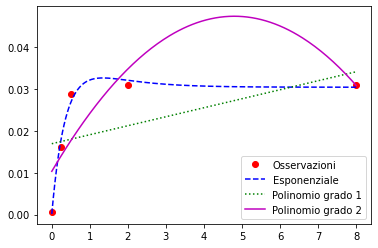

In [14]:
m = 5
x4 = np.array([0.0004, 0.2507, 0.5008, 2.0007, 8.0013]) #[0.001, 0.08, 0.3, 0.6, 2.8 ]
y4 = np.array([0.0007, 0.0162, 0.0288, 0.0309, 0.0310])
M = np.zeros((5, 4))
M[:, 0] = np.ones((5,))
M[:, 1] = np.exp(-x4)
M[:, 2] = np.exp(-2 * x4)
M[:, 3] = np.exp(-3 * x4)

print(M)

print('Rango di M ---->', np.linalg.matrix_rank(M))
print("Con Condizionamento M --> ", np.linalg.cond(M))

# La matrice M è a rango massimo, ha condizionamento 18.45, quindi la marice G delle equazioni
# normali (di dimensioni 4x4) avrebbe indice
# di condizionamento circa 343. Utilizzo il metodo
aexp, resexp = QRLS(M, y4)
xx = np.linspace(np.min(x4), np.max(x4), 200)
polexp = aexp[0]+aexp[1]*np.exp(-xx)+aexp[2]*np.exp(-2*xx)+aexp[3]*np.exp(-3 * xx)

# Calcolo del polinomio approssimante di grado 1
n = 1
n1 = n+1
A1 = np.vander(x4, increasing=True)[:, :n1]
print('Rango di A1 --->', np.linalg.matrix_rank(A1))
print("Condizionamento di A1---> ", np.linalg.cond(A1))

# Matrice a rango massimo e ben condizionata: uso le equazioni normali
alpha1 = eqnorm(A1, y4)
pol1 = np.polyval(np.flip(alpha1), xx)

# Parabola approssimante
n = 2
n1 = n+1
A2 = np.vander(x4, increasing=True)[:, :n1]
print('Rango di A2', np.linalg.matrix_rank(A2))
print("Condizionamento di A2 ", np.linalg.cond(A2))

# Matrice a rango massimo e mediamente mal condizionata: uso qr
alpha2, res2 = QRLS(A2, y4)
pol2 = np.polyval(np.flip(alpha2), xx)
print("quadrato residuo exp", resexp)
print("quadrato residuo pol grado 2 ", res2)

plt.plot(x4, y4, 'ro', xx, polexp, 'b--', xx, pol1, 'g:', xx, pol2, 'm-')
plt.legend(['Osservazioni', 'Esponenziale',
           'Polinomio grado 1', 'Polinomio grado 2'])
